In [2]:
import os

from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy.stats import norm

In [3]:
if not os.path.exists('images'):
    os.makedirs('images')

# Class

In [3]:
class Node:
    def __init__(self, node_id, mean_load, initial_value, variance=1.0):
        """
        初始化节点

        :param node_id: 节点的唯一标识符
        :param mean_load: 节点的负载均值（用于 IID 数据）
        :param initial_value: 节点在 AR(1) 中的初始值
        :param variance: 生成数据的方差，默认为1.0
        """
        self.node_id = node_id
        self.mean_load = mean_load
        self.initial_value = initial_value
        self.variance = variance

        self.load_output = []  # 存储每个时间步的负载输出

        self.latency_output = []  # 存储每个时间步的延迟输出（预留）

    def update_load_output(self, load):
        """
        更新节点的负载输出

        :param load: 当前时间步的负载值
        """
        self.load_output.append(load)

    def update_latency_output(self, latency):
        """
        更新节点的延迟输出（预留接口）

        :param latency: 当前时间步的延迟值
        """
        self.latency_output.append(latency)


In [4]:
class DataHandler:
    def __init__(self, N, T_train, T_test, ini_mean_load, ini_var_load, means_load, var_load, theta, visualizer):
        """
        初始化数据生成器

        :param N: 节点数量
        :param T_train: 用于训练的历史数据时间步长（10000）
        :param T_test: 用于测试的历史数据时间步长（1000）
        :param ini_mean_load: 初始负载均值的均值
        :param ini_var_load: 初始负载均值的方差
        :param means_load: 负载均值列表
        :param var_load: 负载的统一方差
        :param theta: AR(1) 模型参数
        :param visualizer: 可视化工具        
        """
        self.N = N
        self.T_train = T_train
        self.T_test = T_test
        self.ini_mean_load = ini_mean_load
        self.ini_var_load = ini_var_load
        self.means_load = means_load
        self.var_load = var_load
        self.theta = theta
        self.visualizer = visualizer

    def generate_nodes(self):
        """
        生成节点对象列表，并初始化其参数

        :return: 节点对象的列表
        """
        self.visualizer.plot_ini_load_mean(self.N, self.ini_mean_load, self.ini_var_load, self.means_load)

        nodes = []
        for i in range(self.N):
            # IID 模型使用 mean_load 作为均值，AR(1) 使用 mean_load 作为初始值
            node = Node(node_id=i, mean_load=self.means_load[i], initial_value=self.means_load[i],
                        variance=self.var_load)
            nodes.append(node)
        return nodes

    def generate_iid_data(self, nodes):
        """
        为每个节点生成 IID 数据并更新其负载

        :param nodes: 节点对象的列表
        """
        for node in nodes:
            for _ in range(self.T_train + self.T_test):
                # 根据负载均值生成数据
                load = np.random.normal(loc=node.mean_load, scale=np.sqrt(self.var_load))
                node.update_load_output(load)

    def generate_ar1_data(self, nodes):
        """
        为每个节点生成 AR(1) 数据并更新其负载

        :param nodes: 节点对象的列表
        """
        for node in nodes:
            current_value = node.initial_value
            for _ in range(self.T_train + self.T_test):
                # 根据 AR(1) 模型生成数据
                current_value = self.theta * current_value + (1 - self.theta) * node.mean_load + np.random.normal(0, 1)
                node.update_load_output(current_value)

    def assign_data_to_nodes(self, nodes, data_type='iid'):
        """
        将生成的数据分配给节点

        :param nodes: 节点对象的列表
        :param data_type: 数据生成方式，支持 'iid' 和 'ar1'
        """
        if data_type == 'iid':
            self.generate_iid_data(nodes)
        elif data_type == 'ar1':
            self.generate_ar1_data(nodes)
        else:
            raise ValueError("Unsupported data type. Choose 'iid' or 'ar1'.")


In [5]:
class EXP3Algorithm:
    def __init__(self, nodes, gammas, k_values=None, alpha=1, method='normal'):
        """
        初始化 EXP3 算法

        :param nodes: 节点对象的列表
        :param gammas: 探索参数列表，控制探索与利用的平衡
        :param k_values: Top-K 值列表
        :param alpha: 负载奖励参数
        :param method: 负载奖励计算方法
        """

        if k_values is None:
            k_values = [1, 2, 5]
        self.nodes = nodes
        self.N = len(nodes)
        self.gammas = gammas
        self.k_values = k_values

        self.rewards = []
        self.rewards_means = []

        self.optimal_reward = None
        self.optimal_chosen_node = None

        self.alpha = alpha
        self.method = method

    def calculate_top_k_accuracy(self, chosen_nodes, rewards_means, k):
        """
        计算选择的动作的 Top-K 准确率

        :param chosen_nodes: 动作列表
        :param rewards_means: 各个节点的平均奖励
        :param k: top-k 的值
        :return: top-k 准确率
        """
        optimal_actions = np.argsort(rewards_means)[::-1][:k]
        return np.mean(np.isin(chosen_nodes, optimal_actions))

    def calculate_load_reward(self, loads):
        """
        计算负载奖励值
        """
        if self.method == 'normal':
            print()
            print('use 1 / (1 + loads) * alpha normalization')
            print()
            return 1 / (1 + loads) * self.alpha
        elif self.method == 'normal^2':
            print()
            print('use 1 / (1 + loads) * alpha ** 2 normalization')
            print()
            return 1 / (1 + loads) * self.alpha ** 2
        elif self.method == 'max-min':
            print()
            print('use max-min normalization')
            print()
            max_load = np.max(loads)
            min_load = np.min(loads)
            return (max_load - loads) / (max_load - min_load) * self.alpha
        elif self.method == 'z-score':
            print()
            print('use z-score normalization')
            print()
            mean_load = np.mean(loads)
            std_load = np.std(loads)
            return (loads - mean_load) / std_load * self.alpha
        else:
            raise ValueError('Unsupported method. Choose from "normal", "max-min" and "z-score".')

    def run(self, T):
        """
        运行 EXP3 算法，遍历给定的时间步长，对所有 gamma 进行实验

        :param method: 负载奖励计算方法
        :param alpha: 负载奖励参数
        :param T: 总时间步长
        :return: 不同 gamma 下的选择节点列表、后悔值列表
        """
        loads = [node.load_output for node in self.nodes]
        print(f'Loads.shape: {np.array(loads).shape}')
        self.rewards = self.calculate_load_reward(np.array(loads))
        print(f'Rewards.shape: {np.array(self.rewards).shape}')
        self.rewards_means = np.mean(self.rewards, axis=1)
        print(f'Rewards_means: {self.rewards_means}')

        self.optimal_reward = max(self.rewards_means)
        self.optimal_chosen_node = np.argmax(self.rewards_means)
        print(f'Optimal_chosen_node: {self.optimal_chosen_node}')

        all_chosen_nodes = []
        all_regrets = []
        all_accuracies = []

        for gamma in self.gammas:

            weights = np.ones(self.N)
            chosen_counts = np.zeros(self.N)
            probabilities = np.zeros(self.N)

            chosen_nodes = []
            regrets = []

            for t in range(T):
                # 选择节点
                print(f'Weights: {weights}')
                probabilities = (1 - gamma) * (weights / np.sum(weights)) + gamma / self.N
                chosen_node_index = np.random.choice(self.N, p=probabilities)

                chosen_counts[chosen_node_index] += 1

                formatted_probabilities = ', '.join(f'{p:.2f}' for p in probabilities)
                print(f'Probabilities: [{formatted_probabilities}]')

                print(f'Chosen_node_index: {chosen_node_index}')

                # 从被选择的节点获取奖励
                chosen_reward = self.rewards[chosen_node_index][t]
                print(f'Chosen_reward: {chosen_reward}')

                # 更新节点的权重
                estimated_chosen_reward = chosen_reward / probabilities[chosen_node_index]
                weights[chosen_node_index] *= np.exp(gamma * estimated_chosen_reward / self.N)

                # 计算并记录后悔值
                regret = self.optimal_reward - chosen_reward
                regrets.append(regret)

                # 记录选择的动作
                chosen_nodes.append(chosen_node_index)

            all_chosen_nodes.append(chosen_nodes)
            all_regrets.append(regrets)

            accuracies = {k: self.calculate_top_k_accuracy(chosen_nodes, self.rewards_means, k) for k in self.k_values}
            all_accuracies.append(accuracies)

        return all_chosen_nodes, all_regrets, all_accuracies, self.rewards


In [6]:
class Visualizer:
    def __init__(self, output_dir='images', add_info=None):
        """
        初始化可视化工具

        :param output_dir: 输出图片保存的目录
        """
        self.output_dir = output_dir
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    def plot_ini_load_mean(self, N, ini_mean_load, ini_var_load, means_load, title='Initial Load Mean'):
        """
        绘制初始负载数据的均值的分布
        """
        print('Mean Load:', ini_mean_load, '; Variance Load:', ini_var_load)

        # Plotting means_load
        fig, axs = plt.subplots(1, 1, figsize=(12, 6))
        x = np.arange(N)
        y = means_load

        axs.plot(x, y, marker='o', linestyle='-', color='b', label='Means Load')
        axs.set_title(title)
        axs.set_xlabel('Node')
        axs.set_ylabel('Mean Load')
        axs.legend()
        axs.grid(True)

        plt.tight_layout()
        fig.savefig(f'{self.output_dir}/{title}.png')
        plt.show()

    def plot_node_data(self, values, title):
        """
        绘制节点数据的分布和时间序列

        :param values: load or rewards
        :type values: 
        :param nodes: 节点对象列表
        :param title: 图表标题
        """
        fig, axs = plt.subplots(1, 2, figsize=(18, 6))
        time = np.arange(len(values[0]))

        # Plot distributions (left subplot)
        for i, value in enumerate(values):
            mean = np.mean(value)
            std = np.std(value)
            x = np.linspace(mean - 3 * std, mean + 3 * std, 100)
            p = norm.pdf(x, mean, std)
            axs[0].plot(x, p, label=f'Node {i + 1}')
        axs[0].set_title(f'{title} - Distribution')
        axs[0].set_xlabel('Value')
        axs[0].set_ylabel('Density')
        axs[0].legend()
        axs[0].grid(True)

        # Plot smoothed time series (right subplot)
        for i, value in enumerate(values):
            smoothed_data = savgol_filter(value, window_length=51, polyorder=3)
            axs[1].plot(time, smoothed_data, label=f'Node {i + 1}')
        axs[1].set_title(f'{title} - Time Series')
        axs[1].set_xlabel('Time (T)')
        axs[1].set_ylabel('Value')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        fig.savefig(f'{self.output_dir}/{title}.png')
        plt.show()

    def plot_algorithm_results(self, all_chosen_nodes, all_regrets, all_accuracies, gammas, k_values, title):
        """
        绘制算法运行结果，包括单步后悔值、累积后悔值和 Top-K 准确率

        :param all_chosen_nodes: 不同 gamma 下的选择的节点列表
        :param all_regrets: 不同 gamma 下的后悔值列表
        :param all_accuracies: 不同 gamma 下的 Top-K 准确率
        :param gammas: 探索参数列表
        :param k_values: Top-K 值列表
        :param title: 图表标题
        """
        fig, axs = plt.subplots(1, 3, figsize=(20, 6))

        # Plot smoothed single-step regrets
        for i, gamma in enumerate(gammas):
            smoothed_single_step_regrets = savgol_filter(all_regrets[i], window_length=101, polyorder=2)
            axs[0].plot(smoothed_single_step_regrets, label=f'Gamma {gamma}')
        axs[0].set_title('Smoothed Single-Step Regrets')
        axs[0].set_xlabel('Time Steps')
        axs[0].set_ylabel('Regret')
        axs[0].legend()
        axs[0].grid(True)

        # Plot smoothed cumulative regrets
        for i, gamma in enumerate(gammas):
            smoothed_cumulative_regrets = savgol_filter(np.cumsum(all_regrets[i]), window_length=51, polyorder=3)
            axs[1].plot(smoothed_cumulative_regrets, label=f'Gamma {gamma}')
        axs[1].set_title('Smoothed Cumulative Regrets')
        axs[1].set_xlabel('Time Steps')
        axs[1].set_ylabel('Cumulative Regret')
        axs[1].legend()
        axs[1].grid(True)

        # Plot top-k accuracy
        width = 0.15
        x = np.arange(len(k_values))

        for i, gamma in enumerate(gammas):
            top_k_accuracies = [all_accuracies[i][k] for k in k_values]
            bars = axs[2].bar(x + i * width, top_k_accuracies, width, label=f'Gamma {gamma}')
            for bar in bars:
                yval = bar.get_height()
                axs[2].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')
        axs[2].set_title('Top-k Accuracy')
        axs[2].set_xlabel('Top-k')
        axs[2].set_ylabel('Accuracy')
        axs[2].set_xticks(x + width * (len(gammas) - 1) / 2)
        axs[2].set_xticklabels(k_values)
        axs[2].legend()
        axs[2].grid(True)

        plt.suptitle(title)
        plt.tight_layout()
        fig.savefig(f'{self.output_dir}/{title}.png')
        plt.show()

    def plot_chosen_nodes(self, all_chosen_nodes, gammas, title):
        """
        绘制选择的节点（node）图表

        :param all_chosen_nodes: 不同 gamma 下的选择的节点列表
        :param gammas: 探索参数列表
        :param title: 图表标题
        """
        num_plots = len(all_chosen_nodes)
        fig, axs = plt.subplots(num_plots, 1, figsize=(12, 6 * num_plots), constrained_layout=True)

        for i, ax in enumerate(axs):
            ax.plot(all_chosen_nodes[i], marker='o', linestyle='-', color='b',
                    label=f'Chosen Nodes (gamma={gammas[i]})')
            ax.set_title(f'{title} - Chosen Nodes (gamma={gammas[i]})')
            ax.set_xlabel('Time Step')
            ax.set_ylabel('Chosen Node')
            ax.legend()
            ax.grid(True)

        fig.savefig(f'{self.output_dir}/{title}.png')
        plt.show()


In [7]:
class Logger:
    def __init__(self, log_file=None):
        """
        初始化日志记录器

        :param log_file: 日志文件路径，默认为 None 表示不保存到文件
        """
        self.log_file = log_file
        self.logs = []

    def log(self, message):
        """
        记录日志信息

        :param message: 要记录的信息
        """
        log_entry = f"[{self._current_time()}] {message}"
        self.logs.append(log_entry)
        print(log_entry)  # 输出到控制台

    def save_to_file(self):
        """
        将日志信息保存到文件
        """
        if self.log_file:
            with open(self.log_file, 'w') as f:
                for log in self.logs:
                    f.write(log + "\n")
            print(f"Logs saved to {self.log_file}")

    def display_logs(self):
        """
        显示当前所有日志信息
        """
        for log in self.logs:
            print(log)

    def _current_time(self):
        """
        获取当前时间的字符串格式

        :return: 当前时间字符串
        """
        from datetime import datetime
        return datetime.now().strftime("%Y-%m-%d %H:%M:%S")


In [8]:
class ExperimentManager3:
    def __init__(self, data_handler, nodes, exp3_algorithm, visualizer, logger, T, k_values, data_type='iid'):
        """
        初始化实验管理器

        :param data_handler: 数据处理器对象
        :param nodes: 节点对象的列表
        :param exp3_algorithm: EXP3 算法对象
        :param visualizer: 可视化工具
        :param logger: 日志记录器
        :param T: 时间步长
        :param k_values: Top-K 值列表
        :param data_type: 数据类型，'iid' 或 'ar1'
        """
        self.data_handler = data_handler
        self.exp3_algorithm = exp3_algorithm
        self.visualizer = visualizer
        self.logger = logger
        self.T = T
        self.k_values = k_values
        self.data_type = data_type
        self.nodes = nodes

    def setup_experiment(self):
        """
        设置实验环境，生成节点并分配数据
        """
        self.logger.log("Setting up experiment.")
        self.logger.log(f"Nodes_Means: {[node.mean_load for node in self.nodes]}")
        self.logger.log(f"Nodes generated and initialized.")

        # 分配数据
        self.data_handler.assign_data_to_nodes(self.nodes, data_type=self.data_type)
        self.logger.log(f"Data assigned to nodes using {self.data_type} method.")
        self.logger.log(f"Load_output[0]: {[node.load_output[0] for node in self.nodes]}")
        # self.logger.log(f"Load_rewards[0]: {[node.load_rewards[0] for node in self.nodes]}")
        # self.logger.log(f"Load_rewards[10]: {[node.load_rewards[10] for node in self.nodes]}")

    def run_experiment(self):
        """
        运行实验过程，包括算法执行和结果记录
        """
        self.logger.log("Experiment started.")

        # 执行 EXP3 算法，获取不同 gamma 下的结果
        all_chosen_nodes, all_regrets, all_accuracies, rewards = self.exp3_algorithm.run(self.T)

        load = [node.load_output for node in self.nodes]
        self.visualizer.plot_node_data(load, "Node Load Data")
        self.visualizer.plot_node_data(rewards, "Node Load Rewards")

        self.logger.log("Experiment finished.")

        # 记录结果
        for i, gamma in enumerate(self.exp3_algorithm.gammas):
            self.logger.log(f"Results for gamma={gamma}:")
            self.logger.log(f"  Total chosen nodes: {len(all_chosen_nodes[i])}")
            self.logger.log(f"  Total regrets: {sum(all_regrets[i])}")
            self.logger.log(f"  Top-K accuracies: {all_accuracies[i]}")

        # 分析结果
        self.analyze_results(all_chosen_nodes, all_regrets, all_accuracies)

    def analyze_results(self, all_chosen_nodes, all_regrets, all_accuracies):
        """
        分析实验结果，并使用可视化工具显示结果

        :param all_chosen_nodes: 不同 gamma 下的选择的节点列表
        :param all_regrets: 不同 gamma 下的后悔值列表
        """

        # 绘制结果
        self.visualizer.plot_algorithm_results(all_chosen_nodes, all_regrets, all_accuracies,
                                               self.exp3_algorithm.gammas, self.k_values, "EXP3 Results")
        self.visualizer.plot_chosen_nodes(all_chosen_nodes, self.exp3_algorithm.gammas, "Chosen Nodes")

        # 计算最佳 gamma
        best_gamma_index = np.argmin([sum(regrets) for regrets in all_regrets])
        best_gamma = self.exp3_algorithm.gammas[best_gamma_index]
        self.logger.log(f"Best gamma based on cumulative regret: {best_gamma}")
        print(f"Best gamma: {best_gamma}")


In [9]:
def main3():
    # 实验参数
    N = 10  # 节点数量
    T = 1000  # 时间步长
    ini_mean_load = 50
    ini_var_load = 10
    means_load = np.random.normal(loc=ini_mean_load, scale=np.sqrt(ini_var_load), size=N)
    print(means_load)

    var_load = 1  # 负载方差

    theta = 0.5  # AR(1) 模型参数
    # gammas = [0.01, 0.05, 0.1, 0.15, 0.2]  # 探索参数列表
    gammas = [0.01, 0.1, 0.2, 0.3, 0.5, 0.8]  # 探索参数列表
    # data_type = 'iid'  # 数据类型，'iid' 或 'ar1'
    data_type = 'ar1'  # 数据类型，'iid' 或 'ar1'

    alpha = 10  # 负载奖励参数
    methond = 'max-min'  # 负载奖励计算方法

    k_values = [1, 2, 5]  # Top-K 值列表

    # 初始化各个模块
    visualizer = Visualizer()
    data_handler = DataHandler(N, 0, T, ini_mean_load, ini_var_load, means_load, var_load, theta, visualizer)
    nodes = data_handler.generate_nodes()
    # visualizer.plot_node_data()
    print(f'Nodes_id: {[node.node_id for node in nodes]}')
    print(f'Means_load: {[node.mean_load for node in nodes]}')
    print(f'Initial_value: {[node.initial_value for node in nodes]}')
    print(f'Variance: {[node.variance for node in nodes]}')

    print(f'Load_output: {[node.load_output for node in nodes]}')
    # print(f'Load_rewards: {[node.load_rewards for node in nodes]}')
    exp3_algorithm = EXP3Algorithm(nodes, gammas, k_values, alpha, methond)
    logger = Logger(log_file='experiment_log.txt')

    # 初始化实验管理器
    experiment_manager = ExperimentManager3(data_handler, nodes, exp3_algorithm, visualizer, logger, T, k_values,
                                            data_type)

    # 设置实验
    experiment_manager.setup_experiment()

    # 运行实验
    experiment_manager.run_experiment()

    # 保存日志
    logger.save_to_file()


In [10]:
# # 假设我们有10个节点的负载数据
# # 加载数据
# data = pd.read_csv('/mnt/data/EXP4 OOP test1.csv')  # 假设数据是CSV格式
# 
# # 确保数据格式正确
# data.head()
# 
# # 检查数据是否有缺失值
# print(data.isnull().sum())
# 
# # 如果有缺失值，可以选择填充或删除
# data = data.fillna(method='ffill')
# 
# # 假设每一列是一个节点的负载值
# node_data = [data.iloc[:, i].values for i in range(data.shape[1])]

# 定义AR专家类
class ARExpert:
    def __init__(self, node_data, order=5):
        """
        初始化AR专家

        参数:
        - node_data: list, 每个节点的负载数据
        - order: int, AR模型的阶数
        """
        self.node_data = node_data
        self.order = order
        self.models = self._train_models()

    def _train_models(self):
        """
        训练每个节点的AR模型
        """
        models = []
        for node in self.node_data:
            model = AutoReg(node, lags=self.order).fit()
            models.append(model)
        return models

    def predict(self):
        """
        使用训练好的模型进行预测
        """
        predictions = []
        for model in self.models:
            # 预测未来一个时间步
            pred = model.predict(start=len(model.data.endog), end=len(model.data.endog))
            predictions.append(pred)
        return predictions

    def plot_predictions(self, node_index, steps=10):
        """
        绘制预测结果

        参数:
        - node_index: int, 节点的索引
        - steps: int, 预测的步数
        """
        node = self.node_data[node_index]
        model = self.models[node_index]

        # 预测未来steps个时间步
        predictions = model.predict(start=len(node), end=len(node) + steps - 1)

        # 绘制真实值和预测值
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(len(node)), node, label='真实值')
        plt.plot(np.arange(len(node), len(node) + steps), predictions, label='预测值', linestyle='--')
        plt.title(f'节点{node_index}的AR模型预测')
        plt.xlabel('时间')
        plt.ylabel('负载值')
        plt.legend()
        plt.show()

# # 创建AR专家
# ar_expert = ARExpert(node_data=node_data, order=5)
# 
# # 获取预测值
# predictions = ar_expert.predict()
# 
# # 绘制第一个节点的预测结果
# ar_expert.plot_predictions(node_index=0, steps=50)


In [11]:
class EXP4Algorithm:
    def __init__(self, nodes, gammas, k_values=None, alpha=1, method='normal'):
        """
        初始化 EXP3 算法

        :param nodes: 节点对象的列表
        :param gammas: 探索参数列表，控制探索与利用的平衡
        :param k_values: Top-K 值列表
        :param alpha: 负载奖励参数
        :param method: 负载奖励计算方法
        """

        if k_values is None:
            k_values = [1, 2, 5]
        self.nodes = nodes
        self.N = len(nodes)
        self.gammas = gammas
        self.k_values = k_values

        self.rewards = []
        self.rewards_means = []

        self.optimal_reward = None
        self.optimal_chosen_node = None

        self.alpha = alpha
        self.method = method

    def calculate_top_k_accuracy(self, chosen_nodes, rewards_means, k):
        """
        计算选择的动作的 Top-K 准确率

        :param chosen_nodes: 动作列表
        :param rewards_means: 各个节点的平均奖励
        :param k: top-k 的值
        :return: top-k 准确率
        """
        optimal_actions = np.argsort(rewards_means)[::-1][:k]
        return np.mean(np.isin(chosen_nodes, optimal_actions))

    def calculate_load_reward(self, loads):
        """
        计算负载奖励值
        """
        if self.method == 'normal':
            print()
            print('use 1 / (1 + loads) * alpha normalization')
            print()
            return 1 / (1 + loads) * self.alpha
        elif self.method == 'normal^2':
            print()
            print('use 1 / (1 + loads) * alpha ** 2 normalization')
            print()
            return 1 / (1 + loads) * self.alpha ** 2
        elif self.method == 'max-min':
            print()
            print('use max-min normalization')
            print()
            max_load = np.max(loads)
            min_load = np.min(loads)
            return (max_load - loads) / (max_load - min_load) * self.alpha
        elif self.method == 'z-score':
            print()
            print('use z-score normalization')
            print()
            mean_load = np.mean(loads)
            std_load = np.std(loads)
            return (loads - mean_load) / std_load * self.alpha
        else:
            raise ValueError('Unsupported method. Choose from "normal", "max-min" and "z-score".')

    def run(self, T):
        """
        运行 EXP3 算法，遍历给定的时间步长，对所有 gamma 进行实验

        :param method: 负载奖励计算方法
        :param alpha: 负载奖励参数
        :param T: 总时间步长
        :return: 不同 gamma 下的选择节点列表、后悔值列表
        """
        loads = [node.load_output for node in self.nodes]
        print(f'Loads.shape: {np.array(loads).shape}')
        self.rewards = self.calculate_load_reward(np.array(loads))
        print(f'Rewards.shape: {np.array(self.rewards).shape}')
        self.rewards_means = np.mean(self.rewards, axis=1)
        print(f'Rewards_means: {self.rewards_means}')

        self.optimal_reward = max(self.rewards_means)
        self.optimal_chosen_node = np.argmax(self.rewards_means)
        print(f'Optimal_chosen_node: {self.optimal_chosen_node}')

        all_chosen_nodes = []
        all_regrets = []
        all_accuracies = []

        for gamma in self.gammas:

            weights = np.ones(self.N)
            chosen_counts = np.zeros(self.N)
            probabilities = np.zeros(self.N)

            chosen_nodes = []
            regrets = []

            for t in range(T):
                # 选择节点
                print(f'Weights: {weights}')
                probabilities = (1 - gamma) * (weights / np.sum(weights)) + gamma / self.N
                chosen_node_index = np.random.choice(self.N, p=probabilities)

                chosen_counts[chosen_node_index] += 1

                formatted_probabilities = ', '.join(f'{p:.2f}' for p in probabilities)
                print(f'Probabilities: [{formatted_probabilities}]')

                print(f'Chosen_node_index: {chosen_node_index}')

                # 从被选择的节点获取奖励
                chosen_reward = self.rewards[chosen_node_index][t]
                print(f'Chosen_reward: {chosen_reward}')

                # 更新节点的权重
                estimated_chosen_reward = chosen_reward / probabilities[chosen_node_index]
                weights[chosen_node_index] *= np.exp(gamma * estimated_chosen_reward / self.N)

                # 计算并记录后悔值
                regret = self.optimal_reward - chosen_reward
                regrets.append(regret)

                # 记录选择的动作
                chosen_nodes.append(chosen_node_index)

            all_chosen_nodes.append(chosen_nodes)
            all_regrets.append(regrets)

            accuracies = {k: self.calculate_top_k_accuracy(chosen_nodes, self.rewards_means, k) for k in self.k_values}
            all_accuracies.append(accuracies)

        return all_chosen_nodes, all_regrets, all_accuracies, self.rewards


In [12]:
class ExperimentManager4:
    def __init__(self, data_handler, nodes, exp4_algorithm, visualizer, logger, T_train, T_test, k_values, data_type='iid'):
        """
        初始化实验管理器

        :param data_handler: 数据处理器对象
        :param nodes: 节点对象的列表
        :param exp4_algorithm: EXP4 算法对象
        :param visualizer: 可视化工具
        :param logger: 日志记录器
        :param T_train: 用于训练的历史数据时间步长
        :param T_test: 用于测试的历史数据时间步长
        :param k_values: Top-K 值列表
        :param data_type: 数据类型，'iid' 或 'ar1'
        """
        self.data_handler = data_handler
        self.exp4_algorithm = exp4_algorithm
        self.visualizer = visualizer
        self.logger = logger
        self.T_train = T_train
        self.T_test = T_test
        self.k_values = k_values
        self.data_type = data_type
        self.nodes = nodes

    def setup_experiment(self):
        """
        设置实验环境，生成节点并分配数据
        """
        self.logger.log("Setting up experiment.")
        self.logger.log(f"Nodes_Means: {[node.mean_load for node in self.nodes]}")
        self.logger.log(f"Nodes generated and initialized.")

        # 分配数据
        self.data_handler.assign_data_to_nodes(self.nodes, data_type=self.data_type)
        self.logger.log(f"Data assigned to nodes using {self.data_type} method.")
        self.logger.log(f"Load_output[0]: {[node.load_output[0] for node in self.nodes]}")
        self.logger.log(f"load_output_shape: {len(self.nodes[0].load_output)}")
        # self.logger.log(f"Load_rewards[0]: {[node.load_rewards[0] for node in self.nodes]}")
        # self.logger.log(f"Load_rewards[10]: {[node.load_rewards[10] for node in self.nodes]}")

    def train_ar_expert(self):
        """
        训练 AR 专家
        """
        self.logger.log("Training AR expert.")
        # TODO: 训练 AR 专家
        # self.ar_expert = ARExpert([node.load_output for node in self.nodes], order=5)
        self.logger.log("AR expert trained.")
        
    def train_LSTM_expert(self):
        """
        训练 LSTM 专家
        """
        self.logger.log("Training LSTM expert.")
        # TODO: 训练 LSTM 专家
        
        self.logger.log("LSTM expert trained.")
        
    def train_GNN_expert(self):
        """
        训练 GNN 专家
        """
        self.logger.log("Training GNN expert.")
        # TODO: 训练 GNN 专家
        
        self.logger.log("GNN expert trained.")
    
    
    def run_experiment(self):
        """
        运行实验过程，包括算法执行和结果记录
        """
        self.logger.log("Experiment started.")
        
        self.logger.log("Training experts:")
        self.train_ar_expert()
        self.train_LSTM_expert()
        self.train_GNN_expert()

        # 执行 EXP3 算法，获取不同 gamma 下的结果
        all_chosen_nodes, all_regrets, all_accuracies, rewards = self.exp4_algorithm.run(self.T_test)

        load = [node.load_output for node in self.nodes]
        self.visualizer.plot_node_data(load, "Node Load Data")
        self.visualizer.plot_node_data(rewards, "Node Load Rewards")

        self.logger.log("Experiment finished.")

        # 记录结果
        for i, gamma in enumerate(self.exp4_algorithm.gammas):
            self.logger.log(f"Results for gamma={gamma}:")
            self.logger.log(f"  Total chosen nodes: {len(all_chosen_nodes[i])}")
            self.logger.log(f"  Total regrets: {sum(all_regrets[i])}")
            self.logger.log(f"  Top-K accuracies: {all_accuracies[i]}")

        # 分析结果
        self.analyze_results(all_chosen_nodes, all_regrets, all_accuracies)

    def analyze_results(self, all_chosen_nodes, all_regrets, all_accuracies):
        """
        分析实验结果，并使用可视化工具显示结果

        :param all_chosen_nodes: 不同 gamma 下的选择的节点列表
        :param all_regrets: 不同 gamma 下的后悔值列表
        """

        # 绘制结果
        self.visualizer.plot_algorithm_results(all_chosen_nodes, all_regrets, all_accuracies,
                                               self.exp4_algorithm.gammas, self.k_values, "EXP3 Results")
        self.visualizer.plot_chosen_nodes(all_chosen_nodes, self.exp4_algorithm.gammas, "Chosen Nodes")

        # 计算最佳 gamma
        best_gamma_index = np.argmin([sum(regrets) for regrets in all_regrets])
        best_gamma = self.exp4_algorithm.gammas[best_gamma_index]
        self.logger.log(f"Best gamma based on cumulative regret: {best_gamma}")
        print(f"Best gamma: {best_gamma}")


In [13]:
def main4():
    N = 10  # 节点数量
    T_train = 10000  # 用于训练的历史数据时间步长
    T_test = 1000  # 用于测试的历史数据时间步长
    ini_mean_load = 50  # 初始负载均值的均值
    ini_var_load = 10  # 初始负载均值的方差
    means_load = np.random.normal(loc=ini_mean_load, scale=np.sqrt(ini_var_load), size=N)  # 负载均值列表
    print(f"Means Load: {means_load}")
    
    var_load = 1  # 负载方差
    
    theta = 0.5  # AR(1) 模型参数
    
    gammas = [0.01, 0.1, 0.2, 0.3, 0.5, 0.8]  # 探索参数列表
    
    data_type = 'iid'  # 数据类型，'iid' 或 'ar1'
    
    alpha = 10  # 负载奖励参数
    method = 'max-min'  # 负载奖励计算方法
    
    k_values = [1, 2, 5]  # Top-K 值列表
    
    # 初始化各个模块
    visualizer = Visualizer()
    data_handler = DataHandler(N, T_train, T_test, ini_mean_load, ini_var_load, means_load, var_load, theta, visualizer)
    nodes = data_handler.generate_nodes()
    print(f"Nodes ID: {[node.node_id for node in nodes]}")
    print(f"Means Load: {[node.mean_load for node in nodes]}")
    print(f"Initial Value: {[node.initial_value for node in nodes]}")
    print(f"Variance: {[node.variance for node in nodes]}")
    print(f'len_load: {len(nodes[0].load_output)}')
    
    exp4_algorithm = EXP4Algorithm(nodes, gammas, k_values, alpha, method)
    logger = Logger(log_file='experiment_log.txt')
    
    # 初始化实验管理器
    experiment_manager = ExperimentManager4(data_handler, nodes, exp4_algorithm, visualizer, logger, T_train, T_test, k_values, data_type)
    
    # 设置实验
    experiment_manager.setup_experiment()
    
    ar_expert = ARExpert([node.load_output for node in nodes], order=5)
    ar_predictions = ar_expert.predict()
    ar_expert.plot_predictions(node_index=0, steps=50)
    
    # 运行实验
    # experiment_manager.run_experiment()
    
    # 保存日志
    logger.save_to_file()

Means Load: [48.52154817 50.48493689 53.126802   43.53612448 48.98500784 50.48554581
 46.99243315 48.11340968 50.25277728 48.10014934]
Mean Load: 50 ; Variance Load: 10


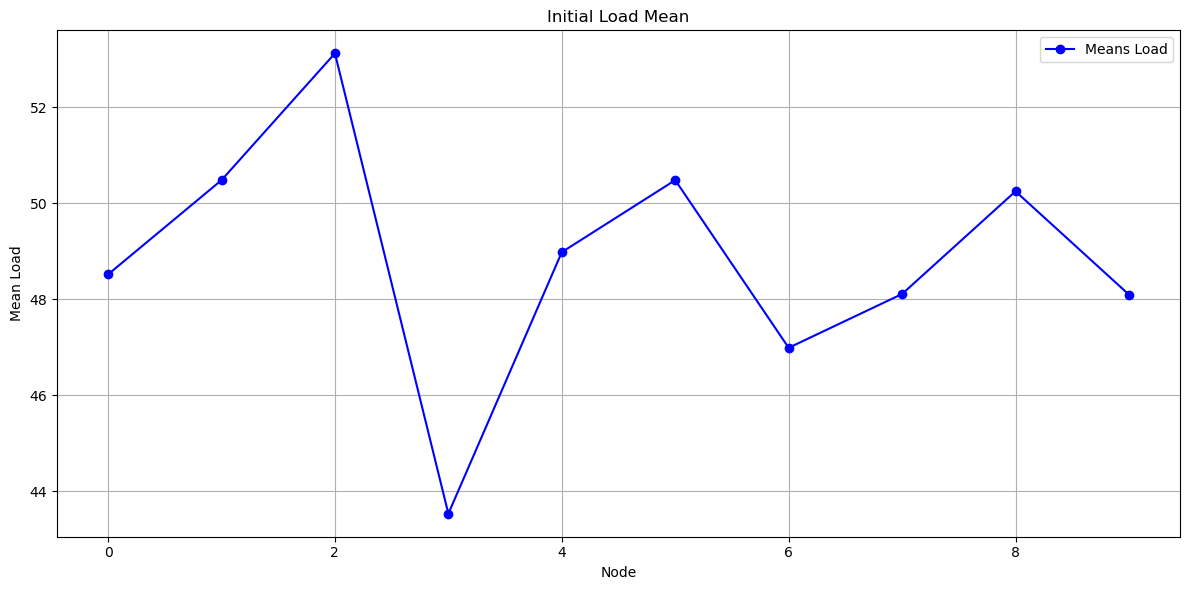

Nodes ID: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Means Load: [48.52154816653801, 50.48493688678933, 53.12680200289617, 43.536124476911745, 48.98500784009034, 50.48554581489897, 46.992433147703395, 48.11340968210592, 50.25277728316634, 48.100149344715646]
Initial Value: [48.52154816653801, 50.48493688678933, 53.12680200289617, 43.536124476911745, 48.98500784009034, 50.48554581489897, 46.992433147703395, 48.11340968210592, 50.25277728316634, 48.100149344715646]
Variance: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
len_load: 0
[2024-08-09 04:08:29] Setting up experiment.
[2024-08-09 04:08:29] Nodes_Means: [48.52154816653801, 50.48493688678933, 53.12680200289617, 43.536124476911745, 48.98500784009034, 50.48554581489897, 46.992433147703395, 48.11340968210592, 50.25277728316634, 48.100149344715646]
[2024-08-09 04:08:29] Nodes generated and initialized.
[2024-08-09 04:08:29] Data assigned to nodes using iid method.
[2024-08-09 04:08:29] Load_output[0]: [48.9479449716908, 51.465217500341474, 53.1732207839382, 43.1

C:\Users\Lenovo\.conda\envs\Project\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36127 (\N{CJK UNIFIED IDEOGRAPH-8D1F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Lenovo\.conda\envs\Project\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36733 (\N{CJK UNIFIED IDEOGRAPH-8F7D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Lenovo\.conda\envs\Project\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Lenovo\.conda\envs\Project\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33410 (\N{CJK UNIFIED IDEOGRAPH-8282}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Lenovo\.conda\envs\Project\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) miss

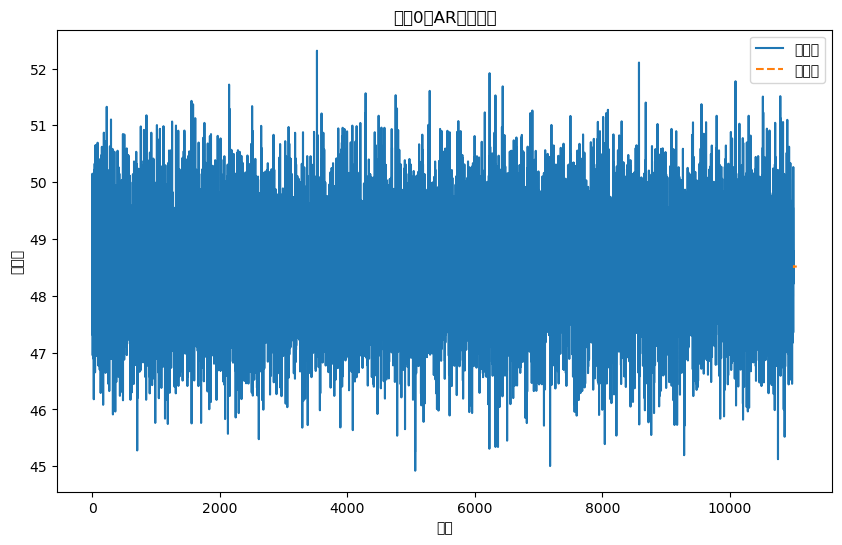

Logs saved to experiment_log.txt


In [14]:
if __name__ == '__main__':
    main4()